In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from lib import make_corrfig, linearize, get_flat_inds_for_net, triangularizeweights
from data_loader import data_loader
import warnings
warnings.simplefilter('ignore')

In [2]:
# Load Demographic data and subject lists
demo = pd.read_csv('data/demo.csv', names=['VC', 'Age', 'Group'])

demo_ts = demo.where(demo.Group=='TS').dropna().reset_index(drop=True)
demo_hc = demo.where(demo.Group=='TFC').dropna().reset_index(drop=True)

# custom data loader reads in connectivity data for each group seperately
ts_con = data_loader(demo_ts)
hc_con = data_loader(demo_hc)

# Connectivity matricies are symettric and square. We need just the flattened upper or lower triangle, of the matrix
# to create a new design matrix

ts_con_flat = linearize(ts_con)
hc_con_flat = linearize(hc_con)


# create feature matrix
X = np.vstack((hc_con_flat, ts_con_flat))

# create label vector: 1 for HC, -1 for TS
y = np.concatenate((np.repeat(1,99), np.repeat(-1,99)))

scaler = StandardScaler()
X_scale = scaler.fit_transform(X)

### Random Forests prototyping

In [3]:
clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_scale,y)
y_pred = clf.predict(X_scale)
scores = (y_pred == y)
print(f'Training Accuracy: {np.mean(scores)}')
print(classification_report(y, y_pred))

Training Accuracy: 1.0
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        99
           1       1.00      1.00      1.00        99

    accuracy                           1.00       198
   macro avg       1.00      1.00      1.00       198
weighted avg       1.00      1.00      1.00       198



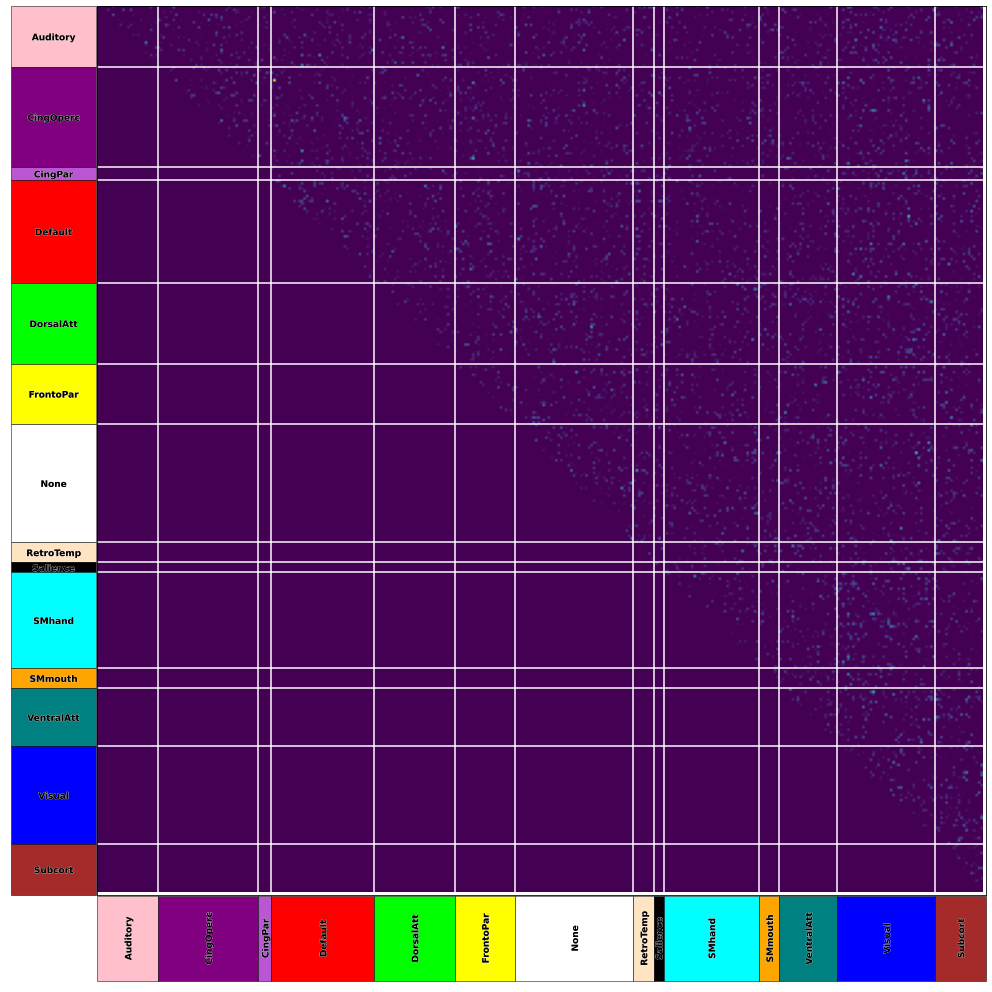

In [6]:
# Visualize feature importance values overlayed ontop of features / functional connectivity matrix
make_corrfig(triangularizeweights(clf.feature_importances_), weights=True) 

The feature importance values are again spread across the brain / functional networks.

Below, we investigate what the mean feature importance in each network is.

In [22]:
netlist = ['Auditory','CingOperc','CingPar','Default','DorsalAtt','FrontoPar','None', 'RetroTemp','Salience','SMhand','SMmouth','VentralAtt','Visual','Subcort']   

mean_importance = []
net_size = []
for net in netlist:
    mean_importance.append(np.mean(clf.feature_importances_[get_flat_inds_for_net(net, within=True)]))
    net_size.append(len(get_flat_inds_for_net(net, within=True)))


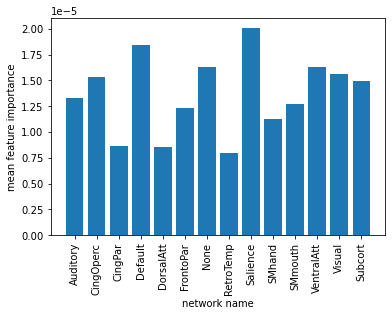

In [23]:
plt.bar(range(len(netlist)), mean_importance, align='center')
plt.xticks(range(len(netlist)), netlist, rotation=90)
plt.ylabel("mean feature importance")
plt.xlabel('network name')
plt.show()

In [24]:
# To do: Refactor below code and set up slurm script to run on HPC

#### LOOCV accuracy, we keep track of feature importance across folds.

In [ ]:
cv = LeaveOneOut()

scores = []
cv_fold_importance = []
fold = 0

for train_ix, test_ix in cv.split(X_scale):
    
    X_train, X_test = X_scale[train_ix, :], X_scale[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    clf = RandomForestClassifier(n_estimators=1500)
    clf.fit(X_train, y_train)
    
    cv_fold_importance.append(clf.feature_importances_)
    scores.append(clf.score(X_test, y_test))

    if fold%50 == 0:
        print(fold)
    fold = fold +1

## Permutation analysis
#### Here we permute sets of features corresponding to a-priori defined groups (functional networks in the brain) 

In [ ]:
cv = LeaveOneOut()
scores = []
netlist = ['Auditory','CingOperc','CingPar','Default','DorsalAtt','FrontoPar','None', 'RetroTemp','Salience','SMhand','SMmouth','VentralAtt','Visual','Subcort']   

# Loop over the LOOCV splits indicies
for train_ix, test_ix in cv.split(X_scale):
    
    # For each split, create the respective training and test set
    X_train, X_test = X_scale[train_ix, :], X_scale[test_ix, :]
    y_train, y_test = y[train_ix], y[test_ix]

    # Train the model
#     clf = svm.SVC(kernel='linear', C=1, random_state=1)
    clf = RandomForestClassifier(n_estimators=1500)

    clf.fit(X_train, y_train)
        
    for net in netlist[:3]:
        
        network_inds = get_flat_inds_for_net(net)
  
        temp_test_sub = np.copy(X_test)

        for j in range(5):

            # Permute the test subjects DMN connections individually 
            for i in range(len(network_inds)):
                randsamp = random.randint(0,98)
                temp_test_sub[0, network_inds[i]] = X_train[randsamp,network_inds[i]]

            # Test the model using the permuted feature set
            loo_score = clf.score(temp_test_sub, y_test)

            # Keep track of the accuracy of the LOOCV with DMN permuted
            scores.append(loo_score)     
            
# with open('results'.txt', 'w') as f:
#     for item in scores:
#         f.write("%s\n" % item)